In [1]:
%matplotlib notebook

import os
import numpy as np
import scipy.linalg as la

from imageio import imread
import matplotlib.pyplot as plt

# Description




In [2]:
def get_faces(path="./faces94"):
    # Traverse the directory and get one image per subdirectory.
    
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg": # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

In [3]:
def compact_SVD(A):
    m,n = A.shape
    
    lambd, V = la.eig(np.matrix(A).H @ A)
    
    singular_vals = np.sqrt(lambd)
    
    # Sorting
    sorting_indices = np.argsort(singular_vals)[::-1]

    singular_vals = singular_vals[sorting_indices]
    sorted_V = np.array([V[:,sorting_indices[i]] for i in range(0, n)]).T
    
    # Calculating the rank
    r = np.sum([i!=0 for i in lambd]) # rank
    
    # Truncated part
    singular_vals_1 = singular_vals[:r]
    V_1 = sorted_V[:,:r]
    
    # Computing for U_1
    U_1 = A @ V_1 / singular_vals_1
    
    return U_1, singular_vals_1, np.matrix(V_1).H

In [4]:
def show_image(image, m=200, n=180):
    '''Accepts an image as a flattened mn-vector'''
    
    # Reshapes the image as an m x n matrix
    plt.imshow(image.reshape((200, 180)), cmap='gray')
    plt.axis('off')

In [5]:
class Facial_Rec:
    def __init__(self, img_dir):
        '''Accepts a path to a directory of images. Constructor computes F, mean, and F_bar'''
        
        # Database of images. Each column is a face
        self.F = get_faces(img_dir)
        
        # Gets the dimensions of F
        self.mn, self.k = self.F.shape
        
        # Gets the mean face
        self.mean = np.mean(self.F, axis=1)
        
        # Gets mean-shifted face of each face
        self.F_bar = np.array([self.F[:,i] - self.mean for i in range(0, self.k)]).T
        
        # Computes compact SVD of F_bar, this is called the eigenfaces matrix
        self.U = compact_SVD(self.F_bar)[0].real #la.svd(self.F_bar, full_matrices=True)[0]#
        
    
    # Methods
    def eigenfaces_and_projection(self, U, s):
            '''Accepts a vector of length mn or an mnxl matrix and an integer s (s < mn). 
               Construct U_s and a projection of the input vector'''
            
            if s > self.mn:
                raise ValueError('s cannot be greater than mn')
                
                
            U_s = U[:,:s]
            F_hat = U_s.T @ self.F_bar
            return U_s, F_hat
        
        
    def index(self, g, s):
        '''Accepts g, an unknown face not in F. We determine which image in the database is most like g.
           Returns the index of the closest matching face'''
        
        U_s, F_hat = self.eigenfaces_and_projection(self.U, s)
        g_hat = U_s.T @ (g - self.mean)
        
        # Smallest error will be chosen
        j = np.argmin([la.norm(F_hat[:,i] - g_hat) for i in range(0, self.k)])
        return j
    
    
    def matching(self, g, s, dim=3600):
        '''Use match method to find the index of the matching face.
           Display the original face along side the best match.'''
        
        j = self.index(g, s)
        
        plt.figure()
        plt.suptitle('s = {}'.format(s))
        plt.subplot(1,2,1)
        show_image(g)
        plt.title('Original Image')
        
        plt.subplot(1,2,2)
        show_image(self.F[:,j])
        plt.title('Matching Image')

# Instantiating

In [6]:
x = Facial_Rec("./faces94")

# Plotting the mean face, original, and mean-shifted

<IPython.core.display.Javascript object>


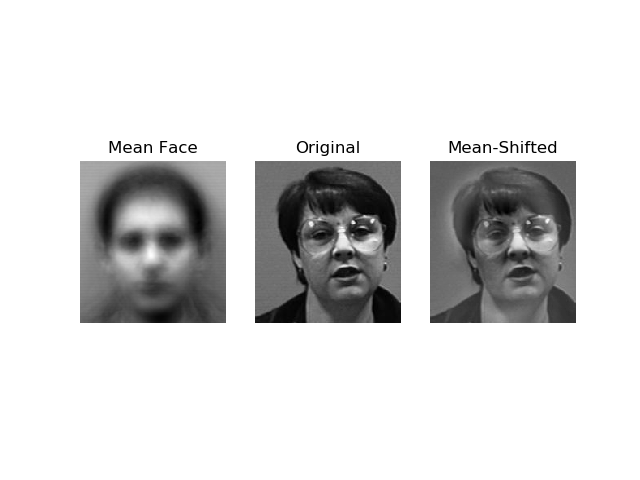

Text(0.5, 1.0, 'Mean-Shifted')

In [7]:
plt.figure()
plt.subplot(1,3,1)
show_image(x.mean)
plt.title('Mean Face')

plt.subplot(1,3,2)
show_image(x.F[:,0])
plt.title('Original')

plt.subplot(1,3,3)
show_image(x.F_bar[:,0])
plt.title('Mean-Shifted')

# Eigenfaces

<IPython.core.display.Javascript object>


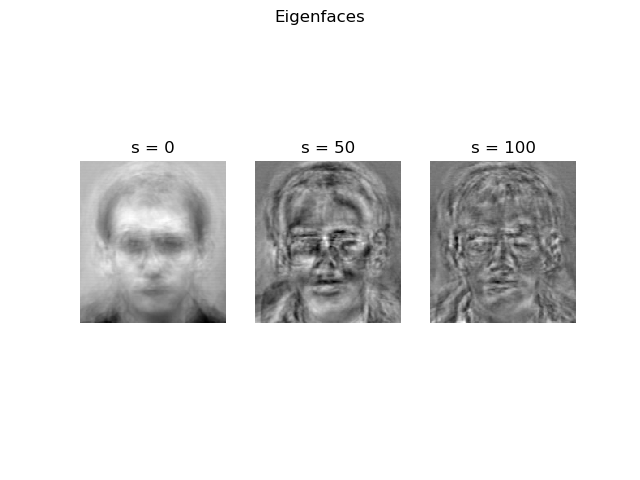

Text(0.5, 0.98, 'Eigenfaces')

In [8]:
plt.figure()

U_s = x.eigenfaces_and_projection(x.U, 120)[0]

s_list = [0, 50, 100]

for i in range(0, len(s_list)):
    plt.subplot(1,len(s_list),i+1)
    show_image(U_s[:,s_list[i]])
    plt.title('s = {}'.format(s_list[i]))
    
plt.suptitle('Eigenfaces')

# Reconstruction

<IPython.core.display.Javascript object>


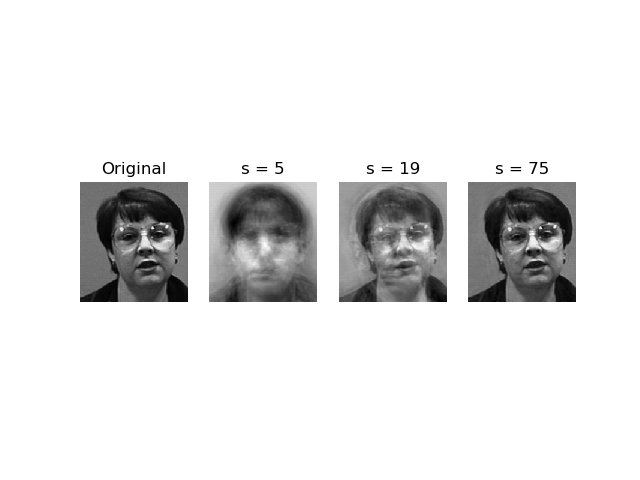

In [9]:
plt.figure()
s_ = [5, 19, 75]
plt.subplot(1,len(s_)+1,1)
show_image(x.F[:,0])
plt.title('Original')


for i in range(0, len(s_)):
    U_s, F_hat = x.eigenfaces_and_projection(x.U, s_[i])
    f_tilde = U_s @ F_hat[:,0] + x.mean
    
    plt.subplot(1,len(s_)+1,i+2)
    plt.title('s = {}'.format(s_[i]))
    show_image(f_tilde)

# Matching

In [10]:
def sample_faces(num_faces, path="./faces94"):
    
    # Get the list of possible images.
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg": # Only get jpg images.
                files.append(dirpath+"/"+fname)
                # Get a subset of the image names and yield the images one at a time.
                
    test_files = np.random.choice(files, num_faces, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

<IPython.core.display.Javascript object>


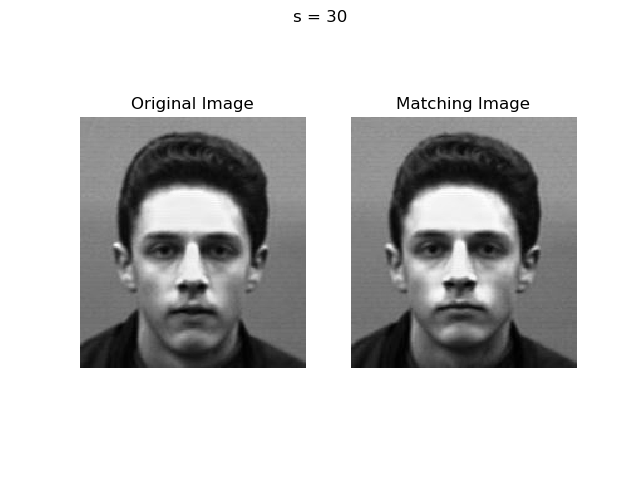

<IPython.core.display.Javascript object>


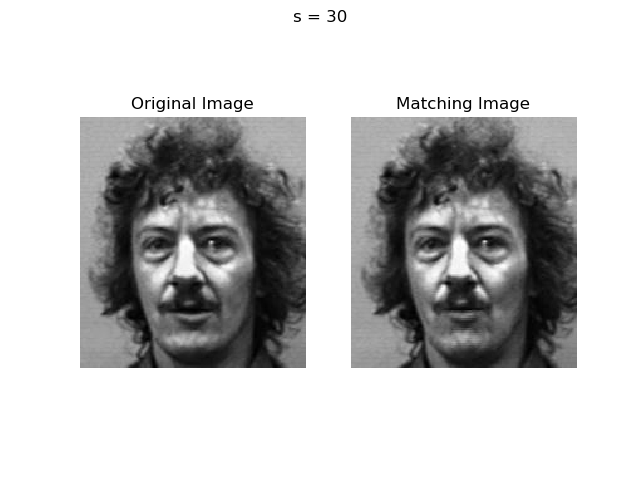

<IPython.core.display.Javascript object>


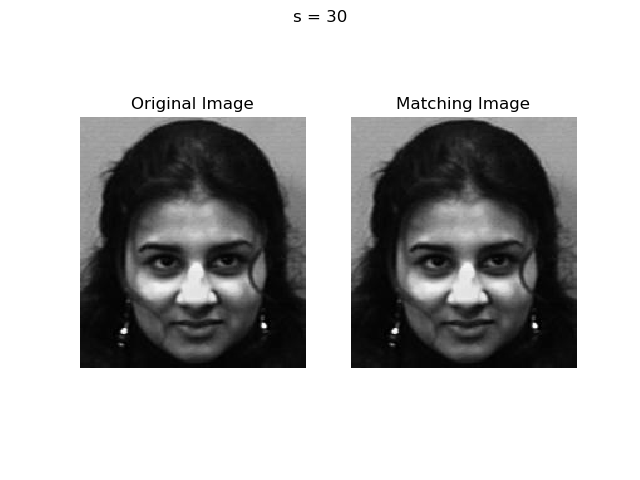

<IPython.core.display.Javascript object>


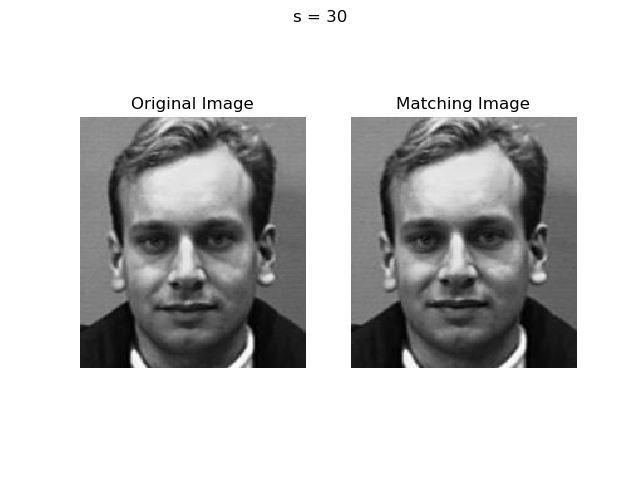

<IPython.core.display.Javascript object>


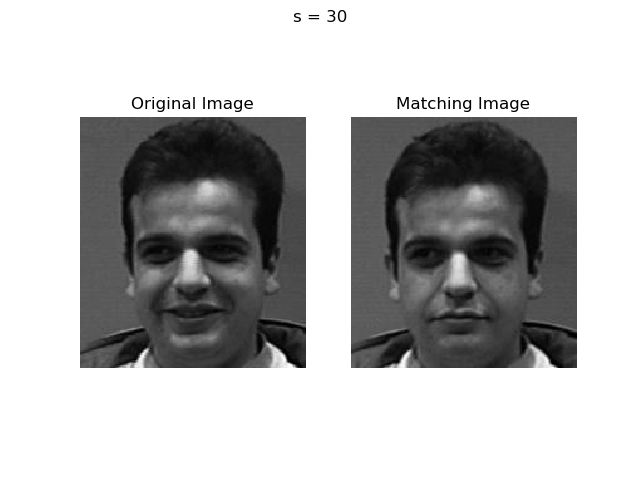

In [11]:
for i in sample_faces(5):
    g = i
    x.matching(g, 30)